In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [29]:
normal_top2000 = pd.read_csv("./Processed/normal_top_2000_HVGs.csv")
cancer_top2000 = pd.read_csv("./Processed/bc_top_2000_HVGs.csv")

top_genes = pd.Series(
    list(set(normal_top2000["gene_id"]).intersection(set(cancer_top2000["V1"])))
)

In [30]:
top_genes

0      ENSG00000207329
1      ENSG00000252749
2      ENSG00000108516
3      ENSG00000272764
4      ENSG00000222691
            ...       
188    ENSG00000186925
189    ENSG00000259962
190    ENSG00000227262
191    ENSG00000261102
192    ENSG00000223977
Length: 193, dtype: object

In [33]:
normal_tpm = pd.read_csv("./Processed/pnas_normal_tpm_normalized_filtered.csv", index_col=0)
cancer_tpm = pd.read_csv("./Processed/pnas_tpm_96_nodup_normalized_filtered.csv", index_col=0)

common_genes = cancer_tpm.index.intersection(normal_tpm.index)

mean_cancer_common = cancer_tpm.loc[common_genes].mean(axis=1)
mean_normal_common = normal_tpm.loc[common_genes].mean(axis=1)
var_cancer_common = cancer_tpm.loc[common_genes].var(axis=1)
var_normal_common = normal_tpm.loc[common_genes].var(axis=1)

mean_diff2_common = (mean_cancer_common - mean_normal_common) ** 2
within_var_common = var_cancer_common + var_normal_common
score_common = mean_diff2_common / (within_var_common + 1e-6)

ranking_df_common = pd.DataFrame({
    "mean_normal": mean_normal_common,
    "mean_cancer": mean_cancer_common,
    "var_normal": var_normal_common,
    "var_cancer": var_cancer_common,
    "score": score_common
}).sort_values("score", ascending=False)

top2000_common = ranking_df_common.head(2000).copy()

In [62]:
normal_top2000 = normal_tpm.loc[top2000_common.index]
normal_top2000.loc["label"] = pd.Series([0]*normal_top2000.shape[1], index=normal_top2000.columns)
cancer_top2000 = cancer_tpm.loc[top2000_common.index]
cancer_top2000.loc["label"] = pd.Series([1]*cancer_top2000.shape[1], index=cancer_top2000.columns)
normal_top2000

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,N23,N24,N25,N26,N27,N28,N29,N30,N31,N32
ENSG00000252316,10.081028,12.455888,13.754107,13.146570,12.157054,12.118723,13.770322,12.454769,13.310041,12.901445,...,12.384197,13.102561,11.803624,11.119506,11.342236,11.004322,12.446571,13.851592,13.297519,10.601921
ENSG00000201861,10.340840,10.100651,13.517955,11.215099,11.911133,11.022114,11.990372,10.383643,12.747639,12.649592,...,11.778955,12.771160,11.628988,11.797335,10.520233,9.293966,11.211933,11.785814,11.696040,9.977933
ENSG00000201098,12.570541,14.862456,15.730768,14.661272,14.146567,14.408505,15.638371,14.289757,16.426511,16.317421,...,14.576376,15.204660,14.170532,14.388329,14.042734,13.395320,14.845861,15.179584,14.746710,13.474427
ENSG00000201413,7.649493,9.503424,12.364603,10.780909,11.213929,9.174478,10.878309,9.135152,11.262733,10.378778,...,9.420250,11.156610,9.932572,9.477027,9.129246,8.597957,10.684689,10.165174,10.169346,8.604703
ENSG00000199839,7.080102,9.363696,12.742263,10.600446,10.226599,10.185292,10.802960,9.994069,11.118748,10.731653,...,10.016571,10.584029,9.138375,9.296725,9.503300,8.196192,9.627321,10.476563,9.182650,8.616745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000126254,2.208685,2.305296,0.000000,5.609616,2.577156,3.518425,4.252466,3.723871,4.429914,5.622001,...,4.600474,4.045761,3.102052,2.545693,4.199715,3.525009,3.251243,0.000000,4.759021,4.467402
ENSG00000226530,0.000000,0.000000,0.000000,0.000000,5.325215,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.864552,3.452834,3.775338,0.000000,0.000000,0.000000,0.000000,5.393752,3.594647
ENSG00000123612,4.663039,2.738858,0.000000,3.030600,4.144467,4.005012,3.948849,4.921258,3.546517,2.161119,...,4.796242,4.199376,3.460796,4.202705,4.378577,3.766519,4.937595,4.719011,3.460758,4.105654
ENSG00000236204,4.102844,0.000000,0.000000,4.232974,5.617067,5.689730,0.000000,0.000000,0.000000,2.199173,...,2.986740,4.035816,4.165475,0.000000,2.082052,3.671181,4.075674,0.000000,4.351564,3.383406


In [63]:
mix_patients = pd.concat([normal_top2000, cancer_top2000], axis=1)
mix_patients

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97
ENSG00000252316,10.081028,12.455888,13.754107,13.146570,12.157054,12.118723,13.770322,12.454769,13.310041,12.901445,...,9.385186,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000201861,10.340840,10.100651,13.517955,11.215099,11.911133,11.022114,11.990372,10.383643,12.747639,12.649592,...,8.178561,0.000000,6.965516,0.000000,0.000000,8.347521,0.000000,0.000000,6.661516,0.000000
ENSG00000201098,12.570541,14.862456,15.730768,14.661272,14.146567,14.408505,15.638371,14.289757,16.426511,16.317421,...,9.150351,0.000000,9.737209,6.687234,9.911671,8.321837,0.000000,6.499632,6.636010,7.693850
ENSG00000201413,7.649493,9.503424,12.364603,10.780909,11.213929,9.174478,10.878309,9.135152,11.262733,10.378778,...,0.000000,0.000000,10.542858,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000199839,7.080102,9.363696,12.742263,10.600446,10.226599,10.185292,10.802960,9.994069,11.118748,10.731653,...,0.000000,0.000000,7.859748,0.000000,0.000000,7.252177,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000126254,2.208685,2.305296,0.000000,5.609616,2.577156,3.518425,4.252466,3.723871,4.429914,5.622001,...,2.546634,5.004245,0.000000,0.000000,0.000000,0.000000,2.422645,0.000000,0.000000,2.650167
ENSG00000226530,0.000000,0.000000,0.000000,0.000000,5.325215,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.829053,0.000000,6.438272,0.000000,0.000000,0.000000,6.804052
ENSG00000123612,4.663039,2.738858,0.000000,3.030600,4.144467,4.005012,3.948849,4.921258,3.546517,2.161119,...,3.784512,4.086237,4.126214,4.705039,4.176319,0.000000,3.868197,4.655007,3.046114,4.647097
ENSG00000236204,4.102844,0.000000,0.000000,4.232974,5.617067,5.689730,0.000000,0.000000,0.000000,2.199173,...,2.203346,4.593963,0.000000,3.134869,3.194469,4.662769,4.753702,4.822833,4.001759,2.301327


In [71]:
validation_tpm = pd.read_csv('./Raw/validation_exon_tpm', sep="\t", header=0, index_col=0)
validation_normal_id = pd.read_excel('./Raw/validation_normal_meta.xlsx', header=0)
validation_tpm = validation_tpm.loc[top2000_common.index]

val_labels = []
for i in validation_tpm.columns:
    if i in list(validation_normal_id["Mapping ID"]):
        val_labels.append(0.0)
    else:
        val_labels.append(1.0)

val_labels = pd.Series(val_labels, index=validation_tpm.columns, name="label").T
test_set = pd.concat([validation_tpm.T, val_labels], axis=1).T

test_set

,BCSC_S5_01,BCSC_S5_02,BCSC_S5_03,BCSC_S5_04,BCSC_S5_05,BCSC_S5_06,BCSC_S5_07,BCSC_S5_08,BCSC_S5_09,BCSC_S5_10,...,BCSC_S6_66,BCSC_S6_67,BCSC_S6_68,BCSC_S6_69,BCSC_S6_70,BCSC_S6_71,BCSC_S6_72,BCSC_S6_73,BCSC_S6_74,BCSC_S6_75
ENSG00000252316,304.922986,602.886920,1405.143972,329.193147,1698.964210,1163.760149,437.486393,390.875100,633.993900,886.512343,...,1016.060560,693.050294,1163.847518,0.000000,1029.807876,200.474097,358.148229,124.513697,128.641811,478.677876
ENSG00000201861,659.292944,0.000000,1325.737802,284.707586,678.172824,365.998278,681.059898,676.108281,411.239287,766.713378,...,2148.067971,1798.184547,366.025755,127.030386,404.838477,346.766005,464.624730,215.375043,222.515565,103.497919
ENSG00000201098,6087.665995,1920.701691,2496.024047,1211.896894,2442.622472,2157.122594,1635.347366,581.124043,3097.032150,1613.878349,...,1630.492462,883.179136,269.660567,748.692365,556.742472,851.571384,608.535045,528.907739,0.000000,508.330488
ENSG00000201413,487.876778,241.154768,0.000000,0.000000,522.758218,84.637102,139.995646,78.175020,253.597560,101.315696,...,722.531954,739.253647,0.000000,58.751554,74.895118,80.189639,1862.370793,199.221915,0.000000,191.471150
ENSG00000199839,737.964875,972.725114,721.357333,531.135161,948.872060,341.393352,635.274359,315.327812,639.321580,510.835444,...,1730.433671,838.649095,256.064236,177.735793,75.524489,161.727002,433.389454,200.896049,311.334804,96.540076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000126254,6.634770,6.559060,16.676892,14.325722,5.687306,9.208026,7.615357,12.757483,6.897486,0.000000,...,0.000000,10.053313,9.208717,9.587742,57.037080,13.086251,15.585780,27.092736,11.196386,15.623213
ENSG00000226530,0.000000,0.000000,0.000000,12.525780,44.754568,0.000000,0.000000,0.000000,54.277718,28.912922,...,0.000000,13.185261,48.310177,0.000000,53.432902,11.442041,10.220639,42.639649,0.000000,13.660249
ENSG00000123612,17.509444,4.720811,5.334671,12.602065,12.280128,14.359313,10.048627,12.242744,19.857558,7.933366,...,18.858909,16.883444,6.627873,8.434155,7.819392,8.372165,10.282886,22.099658,16.116951,6.247020
ENSG00000236204,4.939691,14.649969,20.693680,28.441932,16.937155,17.138799,2.834876,15.830244,5.135286,8.206469,...,14.631089,7.484850,0.000000,28.552898,3.033214,19.485839,20.306751,8.068387,12.503828,7.754485


In [77]:
X_train = mix_patients.drop(index="label")
y_train = mix_patients.loc["label"]

X_test = test_set.drop(index="label")
y_test = test_set.loc["label"]
X_test

,BCSC_S5_01,BCSC_S5_02,BCSC_S5_03,BCSC_S5_04,BCSC_S5_05,BCSC_S5_06,BCSC_S5_07,BCSC_S5_08,BCSC_S5_09,BCSC_S5_10,...,BCSC_S6_66,BCSC_S6_67,BCSC_S6_68,BCSC_S6_69,BCSC_S6_70,BCSC_S6_71,BCSC_S6_72,BCSC_S6_73,BCSC_S6_74,BCSC_S6_75
ENSG00000252316,304.922986,602.886920,1405.143972,329.193147,1698.964210,1163.760149,437.486393,390.875100,633.993900,886.512343,...,1016.060560,693.050294,1163.847518,0.000000,1029.807876,200.474097,358.148229,124.513697,128.641811,478.677876
ENSG00000201861,659.292944,0.000000,1325.737802,284.707586,678.172824,365.998278,681.059898,676.108281,411.239287,766.713378,...,2148.067971,1798.184547,366.025755,127.030386,404.838477,346.766005,464.624730,215.375043,222.515565,103.497919
ENSG00000201098,6087.665995,1920.701691,2496.024047,1211.896894,2442.622472,2157.122594,1635.347366,581.124043,3097.032150,1613.878349,...,1630.492462,883.179136,269.660567,748.692365,556.742472,851.571384,608.535045,528.907739,0.000000,508.330488
ENSG00000201413,487.876778,241.154768,0.000000,0.000000,522.758218,84.637102,139.995646,78.175020,253.597560,101.315696,...,722.531954,739.253647,0.000000,58.751554,74.895118,80.189639,1862.370793,199.221915,0.000000,191.471150
ENSG00000199839,737.964875,972.725114,721.357333,531.135161,948.872060,341.393352,635.274359,315.327812,639.321580,510.835444,...,1730.433671,838.649095,256.064236,177.735793,75.524489,161.727002,433.389454,200.896049,311.334804,96.540076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000253368,0.000000,7.322513,24.824038,21.324252,12.698580,5.139905,21.254400,37.979767,7.700331,135.361052,...,0.000000,16.835230,10.280582,3.567908,4.548287,14.609448,8.699957,0.000000,6.249805,23.255605
ENSG00000126254,6.634770,6.559060,16.676892,14.325722,5.687306,9.208026,7.615357,12.757483,6.897486,0.000000,...,0.000000,10.053313,9.208717,9.587742,57.037080,13.086251,15.585780,27.092736,11.196386,15.623213
ENSG00000226530,0.000000,0.000000,0.000000,12.525780,44.754568,0.000000,0.000000,0.000000,54.277718,28.912922,...,0.000000,13.185261,48.310177,0.000000,53.432902,11.442041,10.220639,42.639649,0.000000,13.660249
ENSG00000123612,17.509444,4.720811,5.334671,12.602065,12.280128,14.359313,10.048627,12.242744,19.857558,7.933366,...,18.858909,16.883444,6.627873,8.434155,7.819392,8.372165,10.282886,22.099658,16.116951,6.247020


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.T)
X_test_scaled = scaler.transform(X_test.T)

pca = PCA(n_components=0.85)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(sum(pca.explained_variance_ratio_))
print(pca.n_components_)
print("NaN in X_train_pca:", np.isnan(X_train_pca).sum())
print("Inf in X_train_pca:", np.isinf(X_train_pca).sum())

(128, 2000)
(161, 2000)
0.8531155436534015
80
NaN in X_train_pca: 0
Inf in X_train_pca: 0


SVC

In [92]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
param_grid = {
    'C': [1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'class_weight': ['balanced'],
    'degree': [2, 3, 4]
}

grid_search = GridSearchCV(
    SVC(),
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_pca, y_train)
print("best parameter composition:", grid_search.best_params_)
print("best cross validation accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
best parameter composition: {'C': 1, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
best cross validation accuracy: 0.992


/Users/pinocchio/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [93]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_pca)

print("\nClassification report:")
print(classification_report(y_test, y_pred))


Classification report:
              precision    recall  f1-score   support

         0.0       0.60      0.79      0.68        78
         1.0       0.72      0.49      0.59        83

    accuracy                           0.64       161
   macro avg       0.66      0.64      0.63       161
weighted avg       0.66      0.64      0.63       161



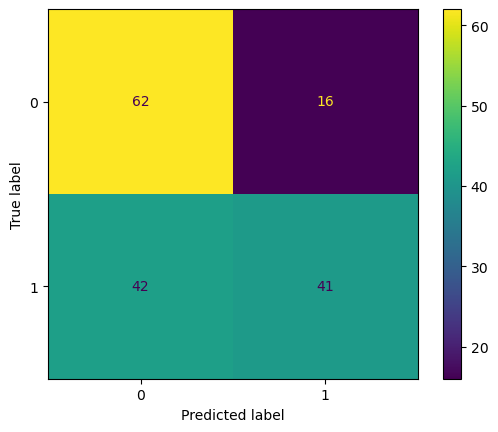

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Dummy

In [85]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_pca, y_train)
print("Dummy accuracy:", dummy.score(X_test_pca, y_test))

Dummy accuracy: 0.515527950310559


Logistic regression

In [86]:
from sklearn.linear_model import LogisticRegression

X_train_shuffled, y_train_shuffled = shuffle(X_train_pca, y_train, random_state=42)

# ElasticNet Logistic Regression
elastic_logreg = LogisticRegression(
    penalty='elasticnet',
    l1_ratio=0.5,
    solver='saga',
    max_iter=3000,
    class_weight='balanced'
)

elastic_logreg.fit(X_train_shuffled, y_train_shuffled)
y_pred_elastic = elastic_logreg.predict(X_test_pca)

print("ElasticNet Logistic Regression")
print(classification_report(y_test, y_pred_elastic))

ElasticNet Logistic Regression
              precision    recall  f1-score   support

         0.0       0.58      0.51      0.54        78
         1.0       0.59      0.65      0.62        83

    accuracy                           0.58       161
   macro avg       0.58      0.58      0.58       161
weighted avg       0.58      0.58      0.58       161



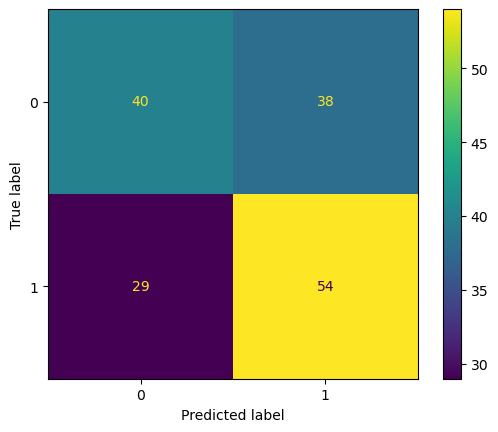

In [87]:
cm = confusion_matrix(y_test, y_pred_elastic)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

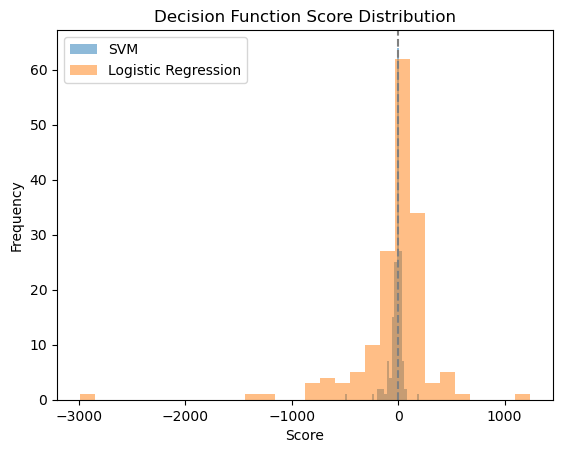

In [88]:
svc_scores = grid_search.decision_function(X_test_pca)
lr_scores = elastic_logreg.decision_function(X_test_pca)

plt.hist(svc_scores, bins=30, alpha=0.5, label='SVM')
plt.hist(lr_scores, bins=30, alpha=0.5, label='Logistic Regression')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Decision Function Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

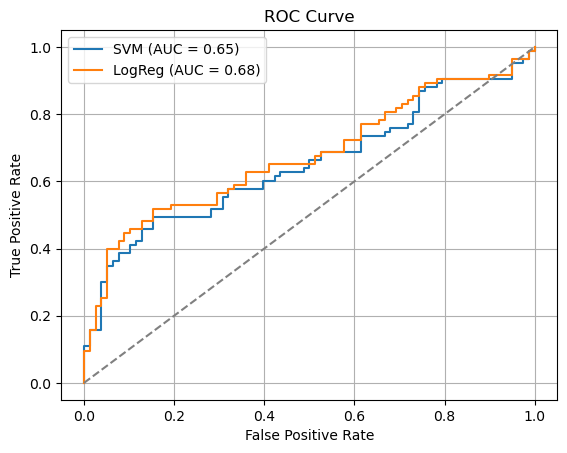

In [89]:
from sklearn.metrics import roc_curve, roc_auc_score

svm_probs = grid_search.decision_function(X_test_pca)
lr_probs = elastic_logreg.decision_function(X_test_pca)

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)

plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_score(y_test, svm_probs):.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC = {roc_auc_score(y_test, lr_probs):.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()